In [380]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [381]:
import numpy as np
import copy
import itertools
from scipy import linalg as sLA
from numpy import linalg as LA
import time
from copy import deepcopy
from scipy.stats import unitary_group
import cmath
from matplotlib import pyplot as plt
import scipy
import scipy.special
import random


import sys
sys.path.append("../scripts")



from Gates import *
from functions import *
from state import *
from Unitary import *

# Классические одномерные случайные блуждания:

In [3]:


N = 50    
pr = 0.5  
i = 0     

def random_walk(pr, N, i):

    position = i

    for j in range(0, N): 

        coin_flip = list(np.random.choice(2, 1, p=[1-pr, pr]))
        position += 2*coin_flip[0]-1

    return position

print("The walker is located at: x = {var}".format(var = random_walk(pr, N, i)))


The walker is located at: x = 18


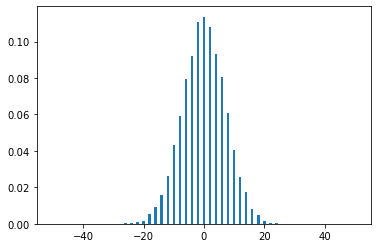

In [4]:
def dist(runs, N):

    positions = range(-1*N, N+1)
    instances = [0 for i in range(-1*N, N+1)]

    for k in range(0, runs):

        result = random_walk(pr, N, i)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n/runs for n in instances])
    plt.show()

dist(10000, N)


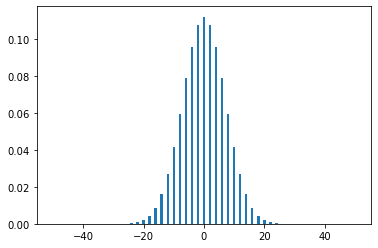

In [5]:
def height_calculate(x, N, pr):

    a = (N + x)/2
    b = (N - x)/2

    if (x%2 == 0):
        var = scipy.special.binom(N, a)*(pr**a)*((1-pr)**b)
    else:
        var = 0
    return var

positions = range(-1*N, N+1)
heights = [height_calculate(x, N, pr) for x in positions]
plt.bar(positions, heights)
plt.show()


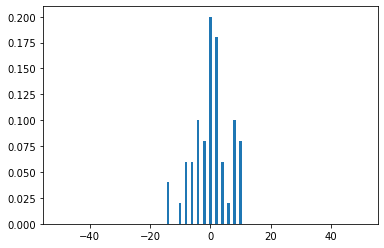

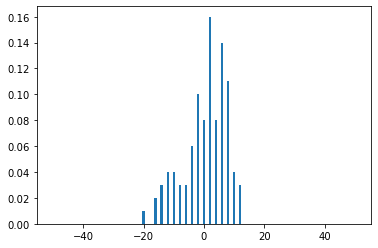

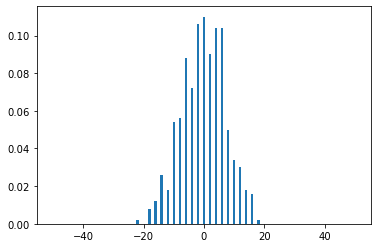

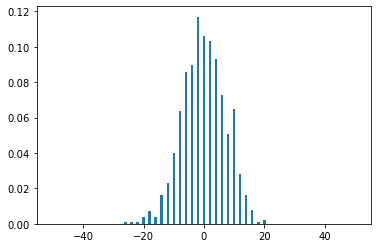

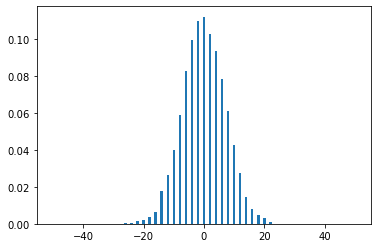

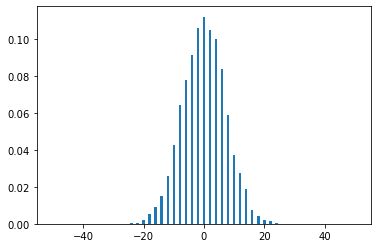

In [6]:
run_range = [50, 100, 500, 1000, 5000, 10000]
for run in run_range:
    dist(run, N)


# Квантовые блуждания

In [382]:
def Addition_operator(state, wires):
    N = len(wires)
    
    for wire in wires[1:]:
        state.apply_U(X(), [wire])

    
    for wire in reversed(range(1,N)):
        local_wires = np.array(list(range(wire+1)))
        state.apply_U(X(), [wire])
        state.apply_long_Toffoli(axis = local_wires)
        
def Subtraction_operator(state, wires):
    N = len(wires)
    
    for wire in range(1,N):
        local_wires = np.array(list(range(wire+1)))
        state.apply_long_Toffoli(axis = local_wires)
        state.apply_U(X(), [wire])
    
    for wire in wires[1:]:
        state.apply_U(X(), [wire])

        

In [383]:
def step(state, wires):
    state.apply_U(H(), [0])
    Subtraction_operator(state, wires)
    state.apply_U(X(), [0])
    Addition_operator(state, wires)
    state.apply_U(X(), [0])
    
def Quantum_walk_linear(state, steps):
    
    
    
    state0 = copy.deepcopy(state)
    state0.split_system(1, int(state.N)-1)
    coef_hist = [state0.get_B_coefs()]
    
    init_time = time.time()
    for s in range(steps):
        step(state0, wires = list(range(state.N)))
        state0.split_system(1, int(state.N)-1)
        coef_hist.append(state0.get_B_coefs())
        
        print('step: ', s)
        print('time: ', time.time() - init_time)
        
    return state0, coef_hist

def projection(a,b):
    a = np.array(a)
    b = np.array(b)
    
    a = a/np.sum(a*a.conj())
    b = b/np.sum(b*b.conj())
    
    p = np.dot(a,b)
    
    return p

def get_statistics(coefs):

    projection_list = []
    num_list = []
    vec_list = []
    for i in range(0, len(coefs)):
        
        num_list.append(i)
        vec = np.zeros(len(coefs))
        vec[i] = 1
        vec_list.append(vec)
        projection_list.append(projection(coefs,vec)**2)
        
    res = np.array([num_list, projection_list])
        
    return res



In [387]:
random.seed(2)

n = 5
state0 = Qpsi(1)
state1 = Qpsi(n)
state = Qpsi(n+1)

state0.build_zero_state()
state0.apply_U(X(), [0])
# state1.build_random_state()
state1.build_zero_state()
state1.apply_U(X(), [0])

state.set_coefs(np.kron(state0.get_coefs(), state1.get_coefs()))

print(state0.get_coefs(),state1.get_coefs(), state.get_coefs())



[0.+0.j 1.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [388]:
steps = 30
res_state, coef_hist = Quantum_walk_linear(state, steps)

step:  0
time:  7.078911304473877
step:  1
time:  14.882651329040527
step:  2
time:  22.02462649345398
step:  3
time:  29.131662130355835
step:  4
time:  36.21945571899414
step:  5
time:  43.29761743545532
step:  6
time:  50.40966820716858
step:  7
time:  57.523682594299316
step:  8
time:  64.60046744346619
step:  9
time:  71.76910328865051
step:  10
time:  78.9104573726654
step:  11
time:  86.07510709762573
step:  12
time:  93.20946526527405
step:  13
time:  100.37406706809998
step:  14
time:  107.69788765907288
step:  15
time:  114.80392956733704
step:  16
time:  122.38481068611145
step:  17
time:  129.54214072227478
step:  18
time:  137.43074536323547
step:  19
time:  144.63879776000977
step:  20
time:  151.80579471588135
step:  21
time:  158.9427330493927
step:  22
time:  166.08058333396912
step:  23
time:  173.20742869377136
step:  24
time:  180.63410544395447
step:  25
time:  188.574645280838
step:  26
time:  196.00726008415222
step:  27
time:  203.28594708442688
step:  28
time: 

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


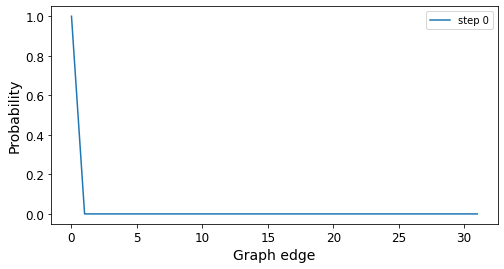

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


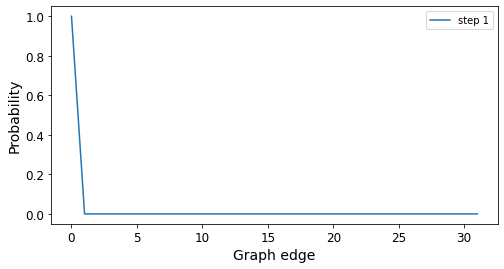

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


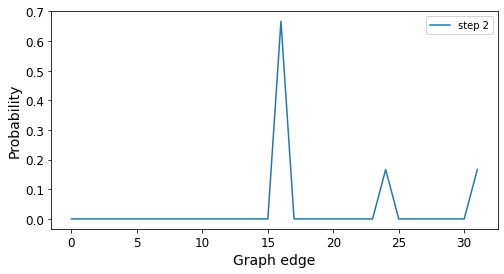

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


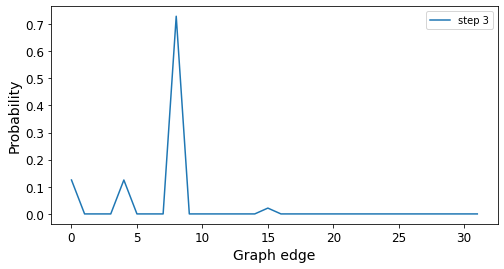

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


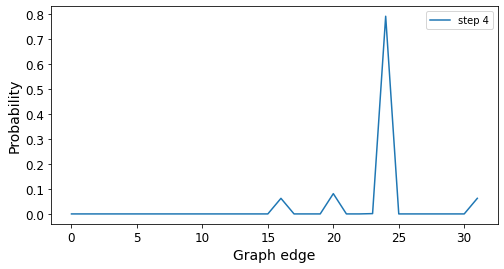

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


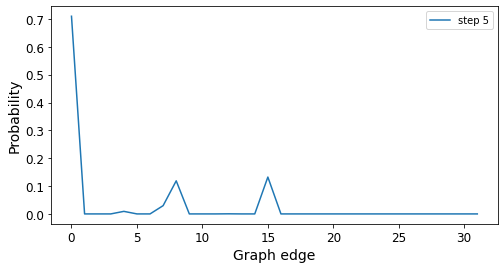

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


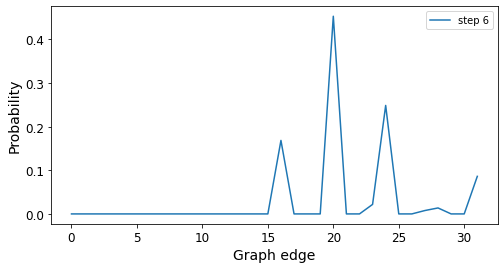

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


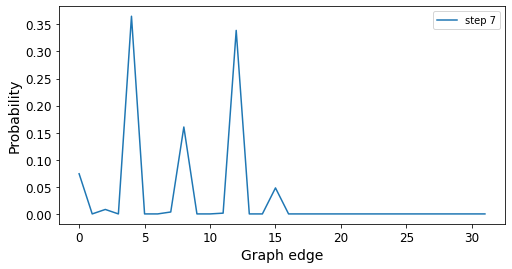

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


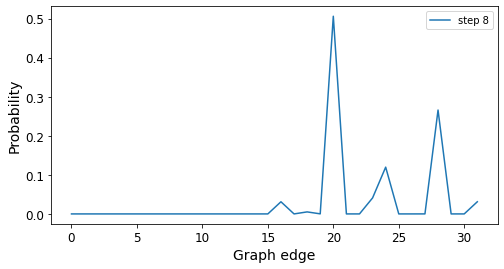

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


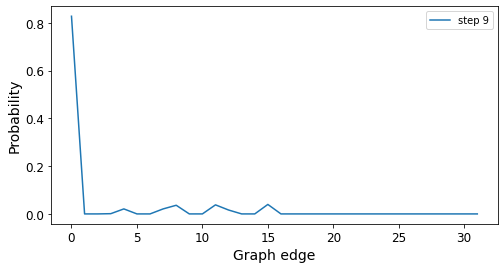

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


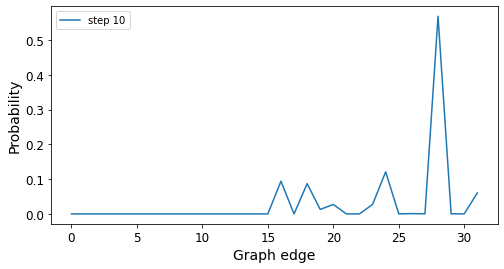

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


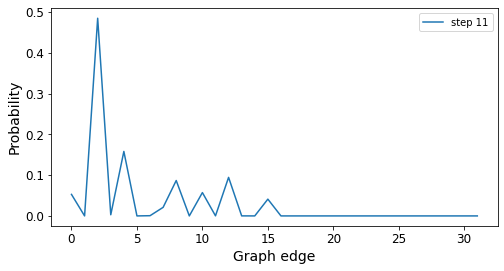

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


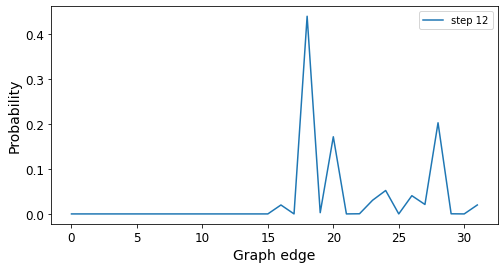

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


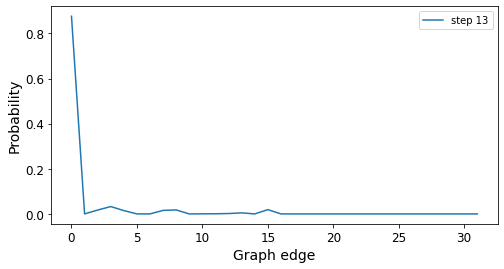

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


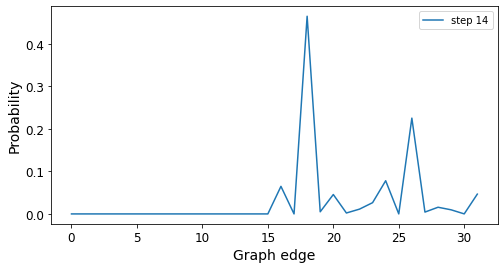

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


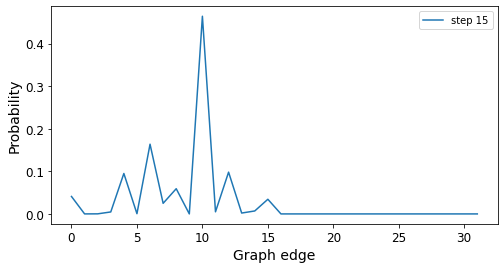

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


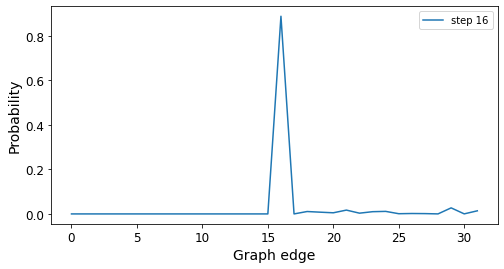

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


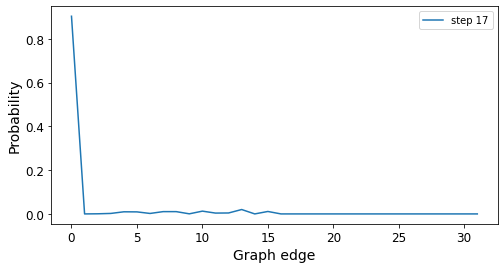

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


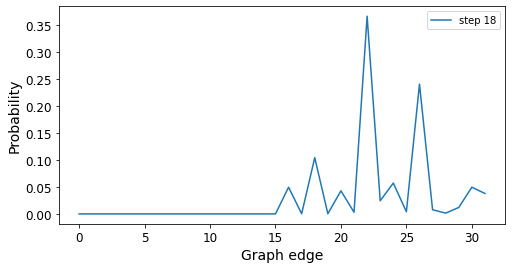

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


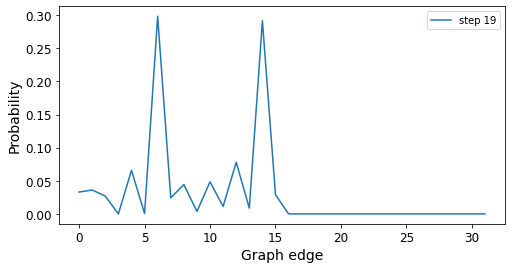

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


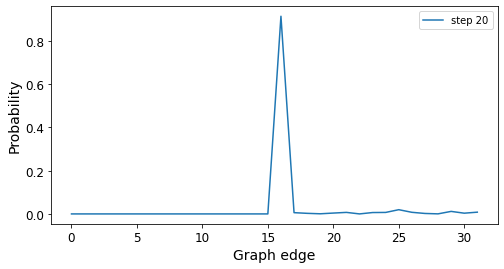

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


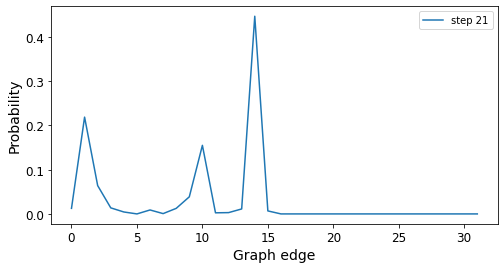

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


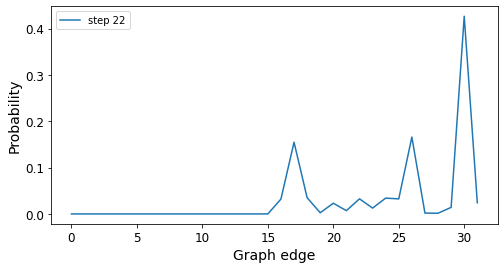

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


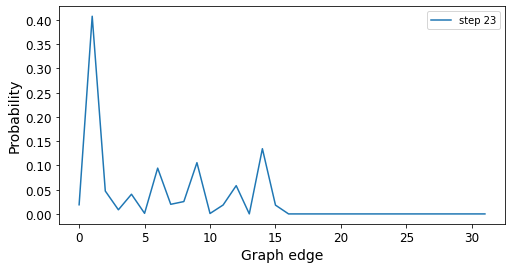

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


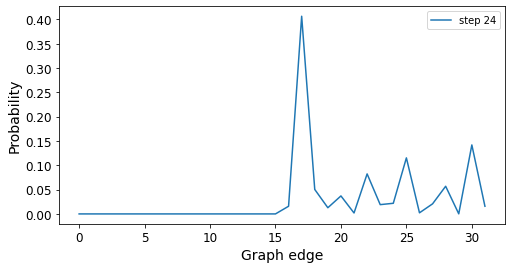

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


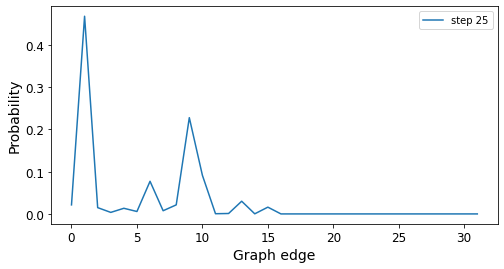

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


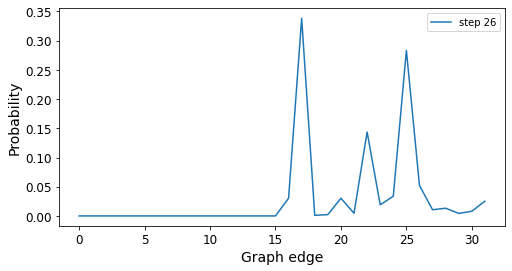

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


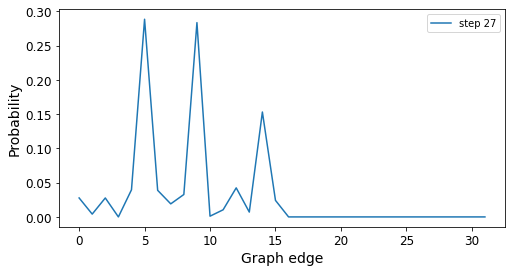

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


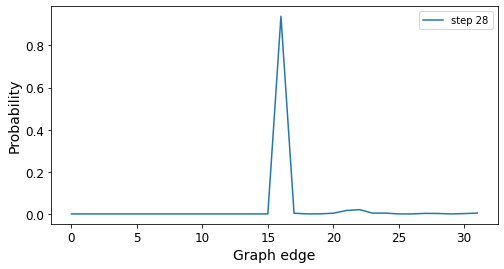

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


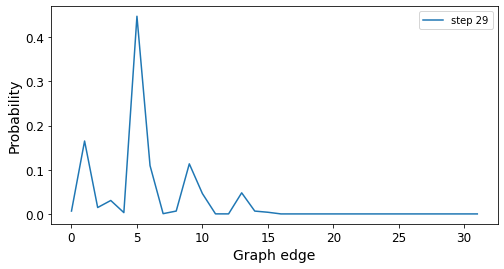

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


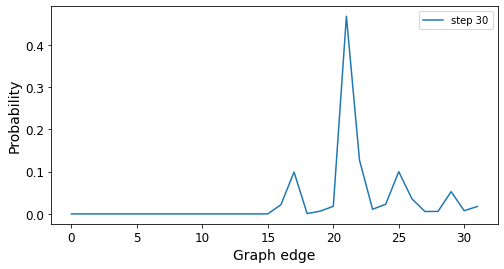

In [390]:
i=0
for coefs in coef_hist:
    plt.figure(figsize = (8,4))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylabel(r'Probability', fontsize = 14)
    plt.xlabel(r'Graph edge', fontsize = 14)
    res = get_statistics(coefs)
    plt.plot(res[0].astype('float'), res[1].astype('float'), label = 'step ' + str(i) )
    plt.legend()
    plt.show()
    i+=1

In [391]:
random.seed(2)

n = 6
state0 = Qpsi(1)
state1 = Qpsi(n)
state = Qpsi(n+1)

state0.build_zero_state()
state0.apply_U(S(), [0])
# state1.build_random_state()
state1.build_zero_state()
state1.apply_U(X(), [0])

state.set_coefs(np.kron(state0.get_coefs(), state1.get_coefs()))

print(state0.get_coefs(),state1.get_coefs(), state.get_coefs())



steps = 30
res_state, coef_hist = Quantum_walk_linear(state, steps)

NameError: name 'S' is not defined

In [ ]:
i=0
for coefs in coef_hist:
    plt.figure(figsize = (8,4))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylabel(r'Probability', fontsize = 14)
    plt.xlabel(r'Graph edge', fontsize = 14)
    res = get_statistics(coefs)
    plt.plot(res[0].astype('float'), res[1].astype('float'), label = 'step ' + str(i) )
    plt.legend()
    plt.show()
    i+=1

# Проверка работы Тоффоли

In [282]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../scripts")



from Gates import *
from functions import *
from state import *
from Unitary import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
state = Qpsi(4)
state.build_zero_state()
print(state.get_coefs())
state.apply_U(X(), [0])
state.apply_U(X(), [1])
state.apply_U(X(), [2])
state.apply_U(X(), [3])

print(state.get_coefs() - apply_long_Toffoli(state.get_coefs(), wires = [0,1,2,3]))


[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[4, 0, 1]
[ 0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j -1.+7.21644966e-16j
  1.-1.74315280e-32j]


In [257]:
state = Qpsi(3)
state.build_zero_state()
print(state.get_coefs())
# state.apply_U(X(), [0])
state.apply_U(X(), [1])
state.apply_U(X(), [2])
print(state.get_coefs(), apply_Toffoli(state.get_coefs(), axis = [1,2,0]))


[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j] [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -3.92523115e-17+1.17756934e-16j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  1.00000000e+00-2.22044605e-16j]
